In [18]:
import sys, os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# DWave Credentials
dwave_solver = "DW_2000Q_2_1"
api_key = 'DEV-3142f58be13a0aacd44657b15b8fb9832ba3bdac'

from dwave.system.samplers import DWaveSampler
from dwave.system.composites import EmbeddingComposite

import dwave_networkx as dnx

### Use NetworkX graphic package to create a signed network
import networkx as nx

# Select a D-Wave system and handle mapping from problem graph to sampler graph
sampler = EmbeddingComposite(DWaveSampler(solver=dwave_solver, token=api_key))

In [19]:
# Import Asset Class data

dataset = 'sp100' # values: 'asset_class','ftse','sectors','sp100'

corr_tensor = np.load('AssetData/' + dataset + '_corr.npy')
dates = np.load('AssetData/' + dataset + '_dates.npy')
nodes = np.load('AssetData/' + dataset + '_nodes.npy')
nodes_descr = np.load('AssetData/' + dataset + '_nodes_descr.npy')

In [38]:
# Helper Functions

def make_graph(corr_mat, node_labels, type):

    G = nx.Graph()
    G.add_nodes_from(node_labels)
    dim = corr_mat.shape[0]

    if not dim == len(node_labels):
        raise ValueError('number node labels not = corr matrix dimensions')

    if type=='signed':
        for i in range(dim):
            for j in range(i+1, dim):
                if corr_mat[i,j] < 0:
                    G.add_edge(node_labels[i], node_labels[j], sign=-1)
                elif corr_mat[i,j] > 0:
                    G.add_edge(node_labels[i], node_labels[j], sign=1)
    
    if type=='corr':
        for i in range(dim):
            for j in range(i+1, dim):
                if not corr_mat[i,j] == 0:
                    G.add_edge(node_labels[i], node_labels[j])
    
    if type=='uncorr':
        for i in range(dim):
            for j in range(i+1, dim):
                if corr_mat[i,j] == 0:
                    G.add_edge(node_labels[i], node_labels[j])
    
    density = (2*G.number_of_edges())/(G.number_of_nodes()*(G.number_of_nodes() - 1))
                
    return G, density

In [60]:
# Create graph for each month and plot frustration over time. Use different thresholds. 
frustration_array = []
date_array = []
density_array = []
threshold_array = []

for i in np.arange(0.1, 1, 0.2):
    
    threshold_array.append(i)
    
    for j in range(1, 26):
        corr_mat = corr_tensor[j*5, :, :]
        
        corr_mat[(corr_mat > -1*i) & (corr_mat < i)] = 0
        G, density = make_graph(corr_mat, nodes, type=G_type)

        try:
            imbalance, bicoloring = dnx.structural_imbalance(G, sampler)
            frustration_score = len(list(imbalance.keys()))/G.number_of_edges()

            frustration_array.append(frustration_score)
            density_array.append(density)
            date_array.append(dates[j*5])
        except:
            print(sys.exc_info()[0])
            print("i: %f, j: %f" % (i,j))

<class 'ValueError'>
i: 0, j: 1
<class 'ValueError'>
i: 0, j: 2
<class 'ValueError'>
i: 0, j: 3
<class 'ValueError'>
i: 0, j: 4
<class 'ValueError'>
i: 0, j: 5
<class 'ValueError'>
i: 0, j: 6
<class 'ValueError'>
i: 0, j: 7
<class 'ValueError'>
i: 0, j: 8
<class 'ValueError'>
i: 0, j: 9
<class 'ValueError'>
i: 0, j: 10
<class 'ValueError'>
i: 0, j: 11
<class 'ValueError'>
i: 0, j: 13
<class 'ValueError'>
i: 0, j: 14
<class 'ValueError'>
i: 0, j: 15
<class 'ValueError'>
i: 0, j: 17
<class 'ValueError'>
i: 0, j: 19
<class 'ValueError'>
i: 0, j: 20
<class 'ValueError'>
i: 0, j: 21
<class 'ValueError'>
i: 0, j: 23
<class 'ValueError'>
i: 0, j: 25
<class 'ValueError'>
i: 0, j: 1
<class 'ValueError'>
i: 0, j: 2
<class 'ValueError'>
i: 0, j: 3
<class 'ValueError'>
i: 0, j: 4
<class 'ValueError'>
i: 0, j: 5
<class 'ValueError'>
i: 0, j: 6
<class 'ValueError'>
i: 0, j: 7
<class 'ValueError'>
i: 0, j: 8
<class 'ValueError'>
i: 0, j: 9
<class 'ValueError'>
i: 0, j: 10
<class 'ValueError'>
i: 0, j

Text(0.5, 1.0, 'Frustration Score vs Time')

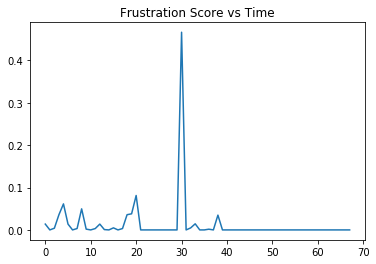

In [64]:
plt.figure(1)
plt.plot(frustration_array)
plt.title("Frustration Score vs Time")

Text(0.5, 1.0, 'Frustration Score vs Graph Density')

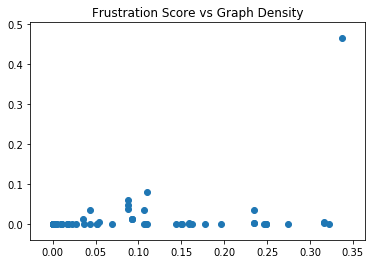

In [65]:
# Plot graph density over time using different thresholds. 
plt.figure(2)
plt.scatter(density_array, frustration_array)
plt.title("Frustration Score vs Graph Density")